<a href="https://colab.research.google.com/github/Sulmon/Deep-Learning/blob/dev_branch/MultiLayerCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Multi-layered CNNs

In the Previous unit we have learned about convolutional filters that can extract patterns from images. For our MNIST classifier we used 9 5x5 filters, reulting in a 9X24X24 tensor.
We can use the same idea of Convolution to extract higher-level patterns in the image. For example, rounded edges of digits such as 8 and 9 can be composed of a number of smaller strokes. To recognize those patterns, we can build another layer of convolution filters on top of the result of the first layer

***The goal of convolution is to discover patterns and the more pattern we stapel a convolution layer on top of another the more complex and detailed the pattern is that we discover***


In [1]:
#installing pytorchcv
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py


--2023-02-14 10:45:05--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.39K  --.-KB/s    in 0s      

2023-02-14 10:45:05 (70.3 MB/s) - ‘pytorchcv.py’ saved [6540/6540]



In [3]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Importing Necessary Libraries

import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
from pytorchcv import load_mnist, train,plot_results,plot_convolution,display_dataset

load_mnist(batch_size = 128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#**Pooling Layers**

First convolutional layers looks for primitive patters, such as horizontal or vertical lines. Next level of convolutional layers on top of them look for higher-level patterns such as primitive shapes. More convolutional layers can combine those shapes into some parts of the picture, up to the final object that we are trying to classify. This creates a hierarchy of extracted patterns.


When doing so we also need to apply one trick: reducing the spatial size of  the image. Once we have detected there is a horizontal stroke within a sliding window, it is not so important at which exact pixel it occured. ***Thus we can "scale down" the size of the image, which is done using one of the pooling layers***:


*   **Average Pooling** take a sliding window (e.g 2x2) and compute an average of values within the window
*   **Max Pooling** replace the window by the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window

WE REDUCE THE SIZE OF THE IMAGE WITH MAX POOLING BECAUSE WE ARE LESS INTERESTED IN THE EXACT PIXEL WHERE THE PATTERN WAS DISCOVERED BUT RATHER THE REGION WHICH IS WHY WE TAKE THE MAX OR AVERAG OF THAT REGION AND UNCOVER EVEN MORE PATTERNS.


Thus a typical CNN will be composed of several convolutional layers with pooling layers in between them to decrease dimensions of the image.We wil also increase th nume number of filters becasue as patterns become more advanced-there are more possible interesting combinations that we need to be looking for.


because of the decreasing spatial dimensions and increasing feature/filters dimensions, this architecture is also called the  **pyramid architecture**


In [5]:
# Using 2 CNN layers

class MultiLayerCNN(nn.Module):
  def __init__(self):
    super(MultiLayerCNN,self).__init__()
    self.conv1 = nn.Conv2d(1,10,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(10,20,5)
    self.fc = nn.Linear(320,10)

  def forward(self,x):
    x = self.pool(nn.functional.relu(self.conv1(x)))
    x = self.pool(nn.functional.relu(self.conv2(x)))
    #instead of using flatten as before we use view which is similar to reshape in 
    #numpySince flattening layer does not have trainable weights, it is not required that we create a separate layer instance within our class - we can just use a function from torch.nn.functional namespace.
    #We use just one instance of pooling layer in our model, also because it does not contain any trainable parameters, and thus one instance can be effectively reused.
    x = x.view(-1,320)
    x = nn.functional.log_softmax(self.fc(x),dim=1)
    return x

In [6]:
net = MultiLayerCNN()
summary(net, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

The number of trainable parameters (~8.5K) is dramatically smaller than in previous cases (80K in Perceptron, 50K in one-layer CNN). This happens because convolutional layers in general have few parameters, independent of the input image size. Also, due to pooling, dimensionality of the image is significantly reduced before applying final dense layer. Small number of parameters have positive impact on our models, because it helps to prevent overfitting even on smaller dataset sizes.

In [17]:
hist = train(net,train_loader,test_loader, epochs=5)

Epoch  0, Train acc=0.949, Val acc=0.979, Train loss=0.001, Val loss=0.000
Epoch  1, Train acc=0.983, Val acc=0.981, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=0.986, Val acc=0.985, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.987, Val acc=0.985, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=0.989, Val acc=0.983, Train loss=0.000, Val loss=0.000


What we observe is that we are able to achieve higher accuracy, and much faster - just with 1 or 2 epochs. It means that ***sophisticated network architecture needs much fewer data to figure out what is going on***, and to extract generic patterns from our images.

## ***Real Images from the CIFAR-10 dataset***

while your handwritten digit recognition problem may seem like a toy problem, we are now ready to do something more serious. Let's explore advance dataset of pictures of different objects, called CIFAR-10. It contains 60K 32x32 color images , divided into 10 classes.

In [18]:
transform =  torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


trainset= torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader= torch.utils.data.DataLoader(trainset,batch_size=14,shuffle=True)
testset= torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


testloader= torch.utils.data.DataLoader(testset,batch_size=14,shuffle=True)


classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


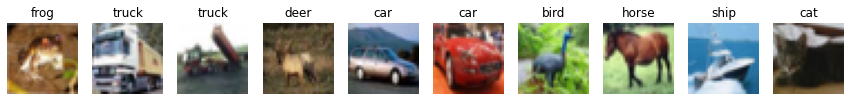

In [19]:
display_dataset(trainset,classes=classes)

A well-known architecture for CIFAR-10 is called [LeNet](https://en.wikipedia.org/wiki/LeNet), and has been proposed by *Yann LeCun*. It follows the same principles as we have outlined above. However, since all images are color, input tensor size is $3\times32\times32$, and the $5\times5$ convolutional filter is applied across color dimension as well - meaning that the size of convolution kernel matrix is $3\times5\times5$. 

We also do one more simplification to this model - we do not use `log_softmax` as output activation function, and just return the output of last fully-connected layer. In this case we can just use `CrossEntropyLoss` loss function to optimize the model.

In [22]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.conv3 = nn.Conv2d(16,120,5)
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(120,64)
    self.fc2 = nn.Linear(64,10)
  
  def forward(self,x):
    x = self.pool(nn.functional.relu(self.conv1(x)))
    x = self.pool(nn.functional.relu(self.conv2(x)))
    x = nn.functional.relu(self.conv3(x))
    x = self.flat(x)
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x



In [23]:
net = LeNet()

summary(net,input_size=(1,3,32,32)) # why is this 1 there ?

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

Training this network properly will take significant amount of time, and should preferably be done on GPU-enabled compute.In order to achieve better training results, we may need to experiment with some training parameters, such as learning rate. Thus, we explicitly define a stochastic gradient descent (SGD) optimizer here, and pass training parameters. You can adjust those parameters and observe how they affect training.

In [24]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net,trainloader, testloader,epochs=3,optimizer= opt,loss_fn= nn.CrossEntropyLoss())

Epoch  0, Train acc=0.235, Val acc=0.369, Train loss=0.147, Val loss=0.122
Epoch  1, Train acc=0.423, Val acc=0.466, Train loss=0.113, Val loss=0.105
Epoch  2, Train acc=0.483, Val acc=0.488, Train loss=0.102, Val loss=0.101


The accuracy that we hav been able to achieve with 3 epochs amounts to which is not great. However,blind guessing would only give us an accuracy of 10% and that out problem is actually significantly more difficult than MNIST digit classification. Getting to almost 50% accuracy in such a short trainint time seem like a good accomplishment.



### **Takeaways**
we have learned the main concept behind computer vision neural networks - convolutional networks. Real-life architectures that power image classification, object detection, and even image generation networks are all based on CNNs, just with more layers and some additional training tricks.